In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, GroverOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.aqua import QuantumInstance

In [2]:
###### Fucntion for creating random adjacency matrix. #########
def create_adjacency_matrix(number_of_vertices, probability):
    adj_matrix = np.ones((number_of_vertices,number_of_vertices))
    for i in range(0,number_of_vertices):
        for j in range(i,number_of_vertices):
            if random.random()>probability or i==j:
                adj_matrix[i,j]=0
                adj_matrix[j,i]=0
    return adj_matrix

In [3]:
def create_quadratic_program(n,adj_matrix):
    qubo = QuadraticProgram()
    linear_coefficients = list()
    summation_terms = dict()
    for i in range(n):
        qubo.binary_var('x'+ str(i) + 'R')
        linear_coefficients.append(-2)
        qubo.binary_var('x' + str(i) + 'G')
        linear_coefficients.append(-2)
        qubo.binary_var('x' + str(i) + 'B')
        linear_coefficients.append(-2)
    for i in range(n):
        for j in ['R','G','B']:
            summation_terms['x'+str(i)+j,'x'+str(i)+j] = summation_terms.get(('x'+str(i)+j,'x'+str(i)+j), 1)
        summation_terms['x'+str(i)+'R','x'+str(i)+'G'] = summation_terms.get(('x'+str(i)+'R','x'+str(i)+'G'), 1)
        summation_terms['x'+str(i)+'G','x'+str(i)+'B'] = summation_terms.get(('x'+str(i)+'G','x'+str(i)+'B'), 1)
        summation_terms['x'+str(i)+'R','x'+str(i)+'B'] = summation_terms.get(('x'+str(i)+'R','x'+str(i)+'B'), 1)
    for i in range(n-1):
        for j in range(i+1,n):
            if adj_matrix[i,j]==1:
                summation_terms['x'+str(i)+'R','x'+str(j)+'R'] = summation_terms.get(('x'+str(i)+'R','x'+str(j)+'R'), 1)
                summation_terms['x'+str(i)+'G','x'+str(j)+'G'] = summation_terms.get(('x'+str(i)+'G','x'+str(j)+'G'), 1)
                summation_terms['x'+str(i)+'B','x'+str(j)+'B'] = summation_terms.get(('x'+str(i)+'B','x'+str(j)+'B'), 1)
    qubo.minimize(constant = n, linear= linear_coefficients, quadratic= summation_terms)
    #print(qubo.export_as_lp_string())
    return qubo
#matrix = np.array([[0,1,1,1,1],[1,0,1,0,0],[1,1,0,1,0],[1,0,1,0,1],[1,0,0,1,0]])
create_quadratic_program(5,create_adjacency_matrix(5,0.5))

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 2 x0R - 2 x0G - 2 x0B - 2 x1R - 2 x1G - 2 x1B - 2 x2R - 2 x2G - 2 x2B
      - 2 x3R - 2 x3G - 2 x3B - 2 x4R - 2 x4G - 2 x4B + [ 2 x0R^2 + 2 x0R*x0G
      + 2 x0R*x0B + 2 x0R*x1R + 2 x0G^2 + 2 x0G*x0B + 2 x0G*x1G + 2 x0B^2
      + 2 x0B*x1B + 2 x1R^2 + 2 x1R*x1G + 2 x1R*x1B + 2 x1R*x2R + 2 x1R*x3R
      + 2 x1G^2 + 2 x1G*x1B + 2 x1G*x2G + 2 x1G*x3G + 2 x1B^2 + 2 x1B*x2B
      + 2 x1B*x3B + 2 x2R^2 + 2 x2R*x2G + 2 x2R*x2B + 2 x2R*x3R + 2 x2R*x4R
      + 2 x2G^2 + 2 x2G*x2B + 2 x2G*x3G + 2 x2G*x4G + 2 x2B^2 + 2 x2B*x3B
      + 2 x2B*x4B + 2 x3R^2 + 2 x3R*x3G + 2 x3R*x3B + 2 x3R*x4R + 2 x3G^2
      + 2 x3G*x3B + 2 x3G*x4G + 2 x3B^2 + 2 x3B*x4B + 2 x4R^2 + 2 x4R*x4G
      + 2 x4R*x4B + 2 x4G^2 + 2 x4G*x4B + 2 x4B^2 ]/2 + 5
Subject To

Bounds
 0 <= x0R <= 1
 0 <= x0G <= 1
 0 <= x0B <= 1
 0 <= x1R <= 1
 0 <= x1G <= 1
 0 <= x1B <= 1
 0 <= x2R <= 1
 0 <= x2G <= 1
 0 <= x2B <= 1
 0 <= x3R <= 1


In [4]:
def result_exact(qubo):
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(qubo)
    return exact_result.fval
qubo = create_quadratic_program(5,create_adjacency_matrix(5,0.5))
#result_exact(qubo)


In [5]:
def result_qaoa(qubo):
    qaoa_mes = QAOA(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qubo)
    return qaoa_result.fval
qubo = create_quadratic_program(5,create_adjacency_matrix(5,0.5))
#result_qaoa(qubo)

In [6]:
def using_vqe(qubo):
    vqe = VQE(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qubo)
    return result.fval
#qubo = create_quadratic_program(5,create_adjacency_matrix(5,0.5))
#using_vqe(qubo)

In [9]:
def main_function(n1,n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost_numpy = list()
    cost_qaoa = list()
    cost_vqe = list()
    time_numpy = list()
    time_qaoa = list()
    time_vqe = list()
    print( "n & brute_force & Numpysolver & QAOA & VQE")
    for i in range(n1,n2):
        for j in range(5):
            adj_matrix = create_adjacency_matrix(i,0.5)
            qubo = create_quadratic_program(i, adj_matrix)

            initial_time = time.time()
            cost_numpy.append(result_exact(qubo))
            final_time = time.time()
            time_numpy.append(final_time - initial_time)

            initial_time = time.time()
            cost_qaoa.append(result_qaoa(qubo))
            final_time = time.time()
            time_qaoa.append(final_time - initial_time)

            initial_time = time.time()
            cost_vqe.append(using_vqe(qubo))
            final_time = time.time()
            time_vqe.append(final_time - initial_time)

        (n, cn, cq, cv) = (i, sum(cost_numpy)/5.0, sum(cost_qaoa)/5.0, sum(cost_vqe)/5.0)
        (n, tn, tq, tv) = (i, sum(time_numpy)/5.0, sum(time_qaoa)/5.0, sum(time_vqe)/5.0)

        print(n, '&', cn, '&', tn, '&', cq, '&', tq, '&', cv, '&', tv)    

        cost_vs_n.append((n, cn, cq, cv))
        time_vs_n.append((n, tn, tq, tv))

        cost_numpy.clear()
        cost_qaoa.clear()
        cost_vqe.clear()
        time_numpy.clear()
        time_qaoa.clear()
        time_vqe.clear()

    return cost_vs_n, time_vs_n

In [10]:
cost_vs_n, time_vs_n = main_function(4, 7)

n & brute_force & Numpysolver & QAOA & VQE
4 & 0.2 & 0.06872854232788086 & 0.2 & 36.63478307723999 & 0.2 & 227.43947467803955
5 & 0.0 & 0.15581059455871582 & 0.0 & 49.550928831100464 & 0.2 & 404.72388463020326
6 & 0.4 & 1.256230640411377 & 1.2 & 25.40757236480713 & 1.0 & 1181.5323023796082


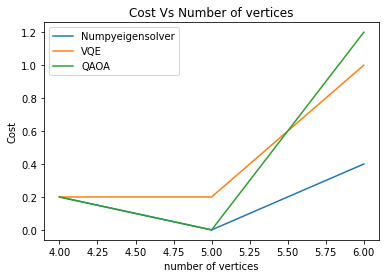

In [11]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
n, cn, cq, cv = zip(*cost_vs_n)
plt.plot(n, cn, label = 'Numpyeigensolver')
plt.plot(n, cv, label = 'VQE')
plt.plot(n, cq, label = 'QAOA')
plt.legend()

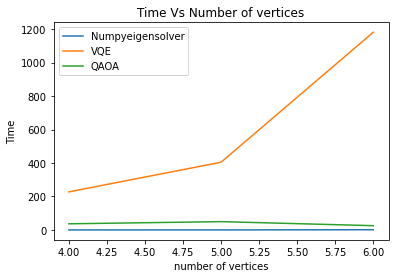

In [12]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
n, tn, tq, tv = zip(*time_vs_n)
plt.plot(n, tn, label = 'Numpyeigensolver')
plt.plot(n, tv, label = 'VQE')
plt.plot(n, tq, label = 'QAOA')
plt.legend()

In [ ]:
import qiskit
qiskit.__qiskit_version__